# Assignment
# Deepankur Lohiya 24008818
# Aayush Thakar 24041785

https://docs.ultralytics.com/datasets/detect/open-images-v7/

In [2]:
import os,gc,random,cv2, albumentations as A, yaml, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
%matplotlib inline

In [6]:
model1 = YOLO('yolov8n.yaml')

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [ ]:
import os
import cv2

# Mapping from class names (as in the downloaded label files) to YOLO class indices.
class_mapping = {
    "Dog": 0,
    "Cat": 1,
    "Fish": 2,
    "Lion": 3,
    "Tiger": 4,
}

def convert_line_to_yolo(line, img_width, img_height):
    """
    Convert a single annotation line to YOLO format.
    Expected format: "ClassName x_min y_min x_max y_max" (pixel coordinates)
    Returns a formatted YOLO line: "<class_idx> <x_center> <y_center> <width> <height>"
    where all coordinates are normalized.
    """
    parts = line.strip().split()
    if len(parts) != 5:
        return None  # Skip lines that do not have exactly 5 items
    class_name, x_min, y_min, x_max, y_max = parts
    if class_name not in class_mapping:
        return None  # Skip if the class is not in our mapping
    try:
        x_min = float(x_min)
        y_min = float(y_min)
        x_max = float(x_max)
        y_max = float(y_max)
    except ValueError:
        return None  # Skip lines with invalid numeric values

    # Calculate normalized center coordinates and box size
    x_center = ((x_min + x_max) / 2.0) / img_width
    y_center = ((y_min + y_max) / 2.0) / img_height
    norm_width = (x_max - x_min) / img_width
    norm_height = (y_max - y_min) / img_height

    class_idx = class_mapping[class_name]
    return f"{class_idx} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}"

def process_label_files(labels_dir, images_dir, output_dir):
    """
    Process each downloaded label file (txt format) in labels_dir,
    convert the annotations to YOLO format using corresponding image dimensions,
    and save the new label files to output_dir.
    """
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            label_path = os.path.join(labels_dir, filename)
            # Assume the corresponding image has the same base name with a .jpg extension.
            image_filename = os.path.splitext(filename)[0] + ".jpg"
            image_path = os.path.join(images_dir, image_filename)
            if not os.path.exists(image_path):
                print(f"Image {image_filename} not found for label {filename}; skipping.")
                continue

            # Load the image to get dimensions
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not load image {image_path}; skipping.")
                continue
            img_height, img_width = image.shape[:2]

            # Read the downloaded label file
            with open(label_path, "r", encoding="utf-8") as f:
                lines = f.readlines()

            yolo_lines = []
            for line in lines:
                yolo_line = convert_line_to_yolo(line, img_width, img_height)
                if yolo_line is not None:
                    yolo_lines.append(yolo_line)
                else:
                    print(f"Skipping invalid or unmapped line in {filename}: {line.strip()}")

            # Write the YOLO-formatted labels to the output directory
            output_path = os.path.join(output_dir, filename)
            with open(output_path, "w", encoding="utf-8") as f:
                for yolo_line in yolo_lines:
                    f.write(yolo_line + "\n")
            print(f"Processed and saved YOLO labels for {filename}")

if __name__ == "__main__":
    # Update these paths as needed:
    downloaded_labels_dir = "path/to/downloaded_labels"   # Directory with downloaded label txt files
    images_dir = "path/to/images"                         # Directory with corresponding image files
    yolo_labels_dir = "path/to/yolo_labels"               # Output directory for YOLO-formatted labels

    process_label_files(downloaded_labels_dir, images_dir, yolo_labels_dir)


cat_0000de486dc6c49f.txt
['cat 181.12 267.519744 465.92 558.72\n', 'cat 654.08 247.68 780.16 540.159744\n']
['cat', '181.12', '267.519744', '465.92', '558.72\n']
['cat', '654.08', '247.68', '780.16', '540.159744\n']
1 181.12 267.519744 465.92 558.72
1 654.08 247.68 780.16 540.159744

cat_00056e547b7c00d6.txt
['cat 181.12 267.519744 465.92 558.72\n', 'cat 654.08 247.68 780.16 540.159744\n']
['cat', '181.12', '267.519744', '465.92', '558.72\n']
['cat', '654.08', '247.68', '780.16', '540.159744\n']
1 181.12 267.519744 465.92 558.72
1 654.08 247.68 780.16 540.159744

cat_00067fe83e3e21c8.txt
['cat 181.12 267.519744 465.92 558.72\n', 'cat 654.08 247.68 780.16 540.159744\n']
['cat', '181.12', '267.519744', '465.92', '558.72\n']
['cat', '654.08', '247.68', '780.16', '540.159744\n']
1 181.12 267.519744 465.92 558.72
1 654.08 247.68 780.16 540.159744

cat_0008ab3d8674f6ca.txt
['cat 181.12 267.519744 465.92 558.72\n', 'cat 654.08 247.68 780.16 540.159744\n']
['cat', '181.12', '267.519744', '465.

In [8]:
print(model1.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [12]:
# Load custom model architecture
# model = YOLO("custom-model.yaml")
# print(model.model)
# Train the model
model1.train(
    data="C:/model/YOLO/dataset/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device="cuda",
    name = "model1"
)


New https://pypi.org/project/ultralytics/8.3.93 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.89  Python-3.13.2 torch-2.8.0.dev20250317+cu126 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=C:/model/YOLO/dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=model1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, em

train: Scanning C:\model\YOLO\dataset\multidata\train\labels.cache... 17229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17229/17229 [00:00<?, ?it/s]

train: WARNING  C:\model\YOLO\dataset\multidata\train\images\tiger_022dea00b8d60294.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\model\YOLO\dataset\multidata\validation\labels.cache... 1277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1277/1277 [00:00<?, ?it/s]


Plotting labels to runs\detect\model1\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\model1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.06G      3.158      4.256      3.996         45        640: 100%|██████████| 1077/1077 [09:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


                   all       1277       1749      0.485     0.0683     0.0511     0.0157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.92G      2.163      3.344       2.73         50        640: 100%|██████████| 1077/1077 [30:44<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


                   all       1277       1749      0.203      0.274      0.177     0.0887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.54G      1.821      2.848       2.26         63        640: 100%|██████████| 1077/1077 [08:46<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


                   all       1277       1749      0.206      0.414      0.224      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.42G      1.687      2.622      2.076         94        640: 100%|██████████| 1077/1077 [37:44<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


                   all       1277       1749      0.222      0.376      0.231      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.9G      1.597      2.426      1.946         39        640: 100%|██████████| 1077/1077 [08:50<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:48<00:00,  1.21s/it]

                   all       1277       1749      0.271      0.488      0.321        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.72G      1.536      2.284      1.876         30        640: 100%|██████████| 1077/1077 [38:47<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [02:13<00:00,  3.33s/it]

                   all       1277       1749      0.355      0.463      0.387      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.87G      1.486        2.2      1.827         63        640: 100%|██████████| 1077/1077 [09:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]

                   all       1277       1749      0.418      0.509      0.442      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.53G      1.451      2.113      1.785        105        640: 100%|██████████| 1077/1077 [08:46<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

                   all       1277       1749      0.524      0.527      0.518       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.93G      1.418      2.048      1.757         41        640: 100%|██████████| 1077/1077 [08:49<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]

                   all       1277       1749       0.53      0.493      0.503      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.04G      1.393      1.985      1.729         79        640: 100%|██████████| 1077/1077 [09:00<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:24<00:00,  1.65it/s]

                   all       1277       1749      0.524      0.586      0.539      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.18G      1.379      1.944      1.706         47        640: 100%|██████████| 1077/1077 [19:47<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:11<00:00,  1.80s/it]

                   all       1277       1749      0.606       0.55      0.581      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.48G      1.359      1.893      1.685        183        640: 100%|██████████| 1077/1077 [09:00<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:09<00:00,  1.75s/it]

                   all       1277       1749      0.599      0.601        0.6      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.49G       1.34      1.855      1.676         82        640: 100%|██████████| 1077/1077 [16:06<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:06<00:00,  1.67s/it]

                   all       1277       1749      0.633      0.649      0.652       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.68G      1.316      1.811       1.65         74        640: 100%|██████████| 1077/1077 [08:50<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]

                   all       1277       1749       0.67      0.638      0.672      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.31G      1.311      1.782      1.636         49        640: 100%|██████████| 1077/1077 [38:37<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [02:15<00:00,  3.38s/it]

                   all       1277       1749      0.679       0.62      0.703      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       5.3G      1.297      1.759      1.628         39        640: 100%|██████████| 1077/1077 [08:55<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]

                   all       1277       1749      0.738      0.606      0.708      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.91G      1.295      1.721       1.62        100        640: 100%|██████████| 1077/1077 [08:55<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

                   all       1277       1749       0.69       0.69      0.719      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.29G      1.275        1.7      1.609         79        640: 100%|██████████| 1077/1077 [08:47<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]

                   all       1277       1749      0.665      0.699      0.724       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.43G      1.268      1.677      1.596         46        640: 100%|██████████| 1077/1077 [08:45<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]

                   all       1277       1749      0.785      0.673      0.749      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.38G      1.256      1.643      1.586         49        640: 100%|██████████| 1077/1077 [10:46<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:46<00:00,  1.16s/it]

                   all       1277       1749      0.724       0.67      0.747      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.83G      1.252      1.639      1.582         84        640: 100%|██████████| 1077/1077 [08:51<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:34<00:00,  1.15it/s]

                   all       1277       1749      0.774      0.676      0.764      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.35G      1.236      1.611      1.572         66        640: 100%|██████████| 1077/1077 [16:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:39<00:00,  2.48s/it]

                   all       1277       1749      0.758      0.715      0.785      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.03G      1.231       1.59      1.557         95        640: 100%|██████████| 1077/1077 [08:56<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]

                   all       1277       1749      0.767      0.681      0.764      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.79G      1.219      1.571      1.549         48        640: 100%|██████████| 1077/1077 [08:51<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

                   all       1277       1749      0.704      0.722      0.773      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.58G       1.22      1.551      1.541         36        640: 100%|██████████| 1077/1077 [08:49<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:28<00:00,  1.40it/s]

                   all       1277       1749      0.725      0.722      0.772      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.49G      1.205      1.535      1.539         51        640: 100%|██████████| 1077/1077 [17:27<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:51<00:00,  1.30s/it]

                   all       1277       1749      0.774      0.699       0.79      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.68G      1.202      1.517       1.53         70        640: 100%|██████████| 1077/1077 [09:10<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:21<00:00,  2.04s/it]

                   all       1277       1749       0.75      0.713      0.781      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.62G       1.19        1.5      1.522         54        640: 100%|██████████| 1077/1077 [08:55<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]

                   all       1277       1749      0.797      0.713      0.798      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.36G      1.181      1.481      1.512         56        640: 100%|██████████| 1077/1077 [08:43<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:47<00:00,  1.20s/it]

                   all       1277       1749      0.808      0.698      0.794      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.88G      1.182      1.465      1.513         37        640: 100%|██████████| 1077/1077 [25:05<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:51<00:00,  2.79s/it]

                   all       1277       1749      0.805      0.715      0.798      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.17G      1.175      1.461      1.509         67        640: 100%|██████████| 1077/1077 [09:47<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]

                   all       1277       1749      0.805      0.727      0.804      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.68G       1.18      1.448      1.506         35        640: 100%|██████████| 1077/1077 [08:57<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:13<00:00,  1.85s/it]

                   all       1277       1749      0.801      0.721      0.801      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.92G      1.162      1.427      1.498         35        640: 100%|██████████| 1077/1077 [39:48<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]

                   all       1277       1749      0.824      0.717        0.8      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.87G      1.156      1.413      1.494         34        640: 100%|██████████| 1077/1077 [09:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [01:05<00:00,  1.63s/it]

                   all       1277       1749      0.781      0.741      0.802      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.25G      1.145      1.401      1.484         91        640: 100%|██████████| 1077/1077 [08:42<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]

                   all       1277       1749      0.848      0.695      0.803      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.97G      1.149      1.384      1.483         42        640: 100%|██████████| 1077/1077 [15:16<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]

                   all       1277       1749       0.83      0.715      0.806      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.85G      1.133      1.371      1.477         37        640: 100%|██████████| 1077/1077 [08:54<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]

                   all       1277       1749      0.799       0.73      0.807      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.72G      1.126      1.363      1.468         76        640: 100%|██████████| 1077/1077 [08:53<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:45<00:00,  1.15s/it]

                   all       1277       1749      0.838      0.702      0.799      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.36G      1.133      1.362      1.468         57        640: 100%|██████████| 1077/1077 [15:30<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:48<00:00,  1.22s/it]

                   all       1277       1749      0.822       0.74      0.814      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.06G      1.121      1.342      1.462         67        640: 100%|██████████| 1077/1077 [08:57<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]

                   all       1277       1749      0.868      0.724      0.817      0.667


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Exception in thread Thread-56 (_pin_memory_loop):
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
    ~~~~~~~~~~~^^
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\site-packages\torch\utils\data\_utils\pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "c:\ProgramData\anaconda3\envs\YOLO\Lib\multiprocessing\queues.py", line 120, in get
    retur


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1077 [00:00<?, ?it/s]


RuntimeError: Pin memory thread exited unexpectedly

In [1]:
metrics = model1.val(data="C:/model/YOLO/dataset/dataset.yaml")
# print(f"mAP50: {metrics['mAP50']:.3f}, Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}")

NameError: name 'model1' is not defined

In [9]:
model1 = YOLO('./runs/detect/model1/weights/best.pt')

In [10]:
metrics = model1.val()

Ultralytics 8.3.89  Python-3.13.2 torch-2.8.0.dev20250317+cu126 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\model\YOLO\dataset\multidata\validation\labels.cache... 1277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1277/1277 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:14<00:00,  5.70it/s]


                   all       1277       1749      0.868      0.724      0.817      0.667
                   Dog        500        597      0.931      0.818      0.924      0.771
                   Cat        345        389      0.931      0.839      0.944      0.816
                  Fish        356        675      0.665      0.443      0.494      0.344
                  Lion         57         65       0.82      0.738      0.805      0.692
                 Tiger         19         23      0.993      0.783      0.915      0.712
Speed: 0.3ms preprocess, 4.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\val2


In [26]:
df = pd.read_csv('C:/model/YOLO/runs/detect/model1/results.csv')
df.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   595.662         3.15815         4.25586         3.99622   
1      2  2538.690         2.16348         3.34415         2.73033   
2      3  3097.150         1.82071         2.84839         2.26050   
3      4  5429.600         1.68650         2.62184         2.07575   
4      5  6011.280         1.59731         2.42572         1.94571   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.48511            0.06831           0.05107   
1               0.20299            0.27354           0.17748   
2               0.20639            0.41402           0.22379   
3               0.22160            0.37640           0.23126   
4               0.27085            0.48834           0.32052   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.01574       2.39480       4.16355       3.46219  0.003330   
1              0.08872       1.71994       2.77362       2.43061  0.006532   
2              0.12402       1.51414       2.43860       2.10224  0.009601   
3              0.12871       1.45443       2.24695       1.94733  0.009406   
4              0.20028       1.32054       2.08803       1.82019  0.009208   

     lr/pg1    lr/pg2  
0  0.003330  0.003330  
1  0.006532  0.006532  
2  0.009601  0.009601  
3  0.009406  0.009406  
4  0.009208  0.009208

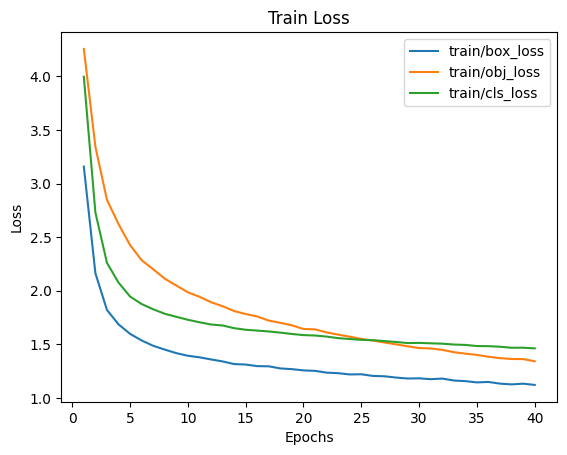

In [37]:
plt.plot(df['epoch'],df['train/box_loss'],label='train/box_loss')
plt.plot(df['epoch'],df['train/cls_loss'],label='train/obj_loss')
plt.plot(df['epoch'],df['train/dfl_loss'],label='train/cls_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.show()

In [20]:
results = model1("C:/model/YOLO/dataset/multidata/test/images/test.jpg", save = True)
for r in results:
    r.show()



image 1/1 C:\model\YOLO\dataset\multidata\test\images\test.jpg: 640x640 1 Dog, 1 Cat, 1 Fish, 1 Lion, 1 Tiger, 10.5ms
Speed: 494.1ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict2
